# Extracting Dynamic Benthic Pelagic Model (DBPM) inputs for a region of interest
**Author:** Denisse Fierro Arcos  
**Date:** 2024-10-17  

The first step of this workflow ([01_processing_dbpm_global_inputs](scripts/01_processing_dbpm_global_inputs.ipynb)), we show how to prepare all DBPM inputs at a global scale.  
  
For this project, we will focus on running DBPM within the boundaries of the [FAO Major Fishing Area 58: Indian Ocean, Antarctic And Southern](https://www.fao.org/fishery/en/area/fao:58/en). If you do not already have a copy, you can download the FAO Major Fishing Areas shapefile from the [FAO website](https://www.fao.org/fishery/en/area).  
  
In this notebook, we will show how to create a mask to extract data from the DBPM global processed in [step 01](scripts/01_processing_dbpm_global_inputs.ipynb).  

## Loading relevant libraries

In [7]:
import os
os.chdir('/g/data/vf71/la6889/dbpm_southern_ocean/scripts/')
import xarray as xr
import pandas as pd
import geopandas as gp
import regionmask
import numpy as np
from glob import glob
from dask.distributed import Client
import useful_functions as uf

## Start a cluster

In [3]:
client = Client(threads_per_worker = 1)

## Loading FAO Major Fishing Areas shapefile
Note that you can replace this shapefile with another describing your region of interest. The only requirement is that your shapefile has the coordinate reference system (CRS) as the grid you will use to create a mask.  
  
In our case, the CRS of our grid is `WGS84`, so the CRS in our shapefile is also `WGS84`.

<Axes: >

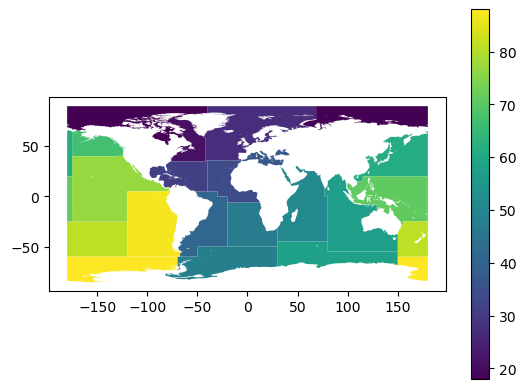

In [2]:
shp_path = '/g/data/vf71/shared_resources/fao_fishing_areas/FAO_MajorAreas_corrected.shp'
fao = gp.read_file(shp_path)

#Making sure F_CODE column containing unique region IDs is an integer
fao['F_CODE'] = fao.F_CODE.astype(int)

#Plotting shapefile
fao.plot(column = 'F_CODE', legend = True)

## Loading DBPM inputs
We will create a mask that matches the grid of our DBPM inputs, so we can subset data easily. We will select `areacello` because it has two dimensions. We do not need a `time` dimension to create the mask. 

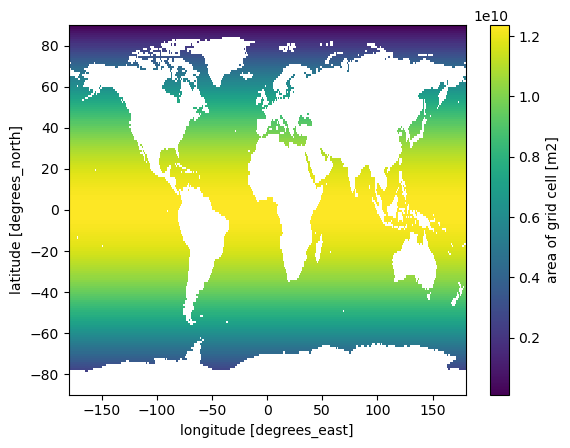

In [15]:
#Grid resolution
res = '1deg'
#Translate to arcmin
if res == '1deg':
    res_am = '60arcmin'
elif res == '025deg':
    res_am = '15arcmin'

input_file = os.path.join(f'/g/data/vf71/la6889/dbpm_inputs/global_gridded/{res}', 
                          f'gfdl-mom6-cobalt2_areacello_{res_am}_global_fixed.zarr/')

#We include the name of the variable stored in the file to load it as a Data Array
ds = xr.open_zarr(input_file)['cellareao']

#Plotting result
ds.plot()

We want our mask to look exactly like the map above.

## Creating gridded mask for FAO Major Fishing Areas

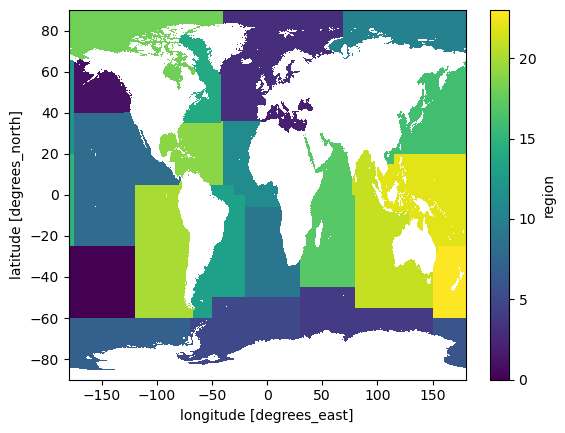

In [34]:
mask = regionmask.mask_geopandas(fao, lon_or_obj = ds['lon'], lat = ds['lat'])

#Plotting result
mask.plot()

You may have noticed that the colourbar in the map above goes from 0 to about 25, but the original shapefile goes to about 90. This is because `regionmask` is using the row indices as the values identifying each FAO Major Fishing Area. We can choose any column in our shapefile to be used for this purpose, but the column **MUST** have unique values identifying each row. This is not the case in our shapefile as areas that cross the international date line (e.g., see the Pacific basin) are split in two in our shapefile.  

The good news is that we can change the values used to identify the Fishing Areas to match the information in our shapefile. We will use the `F_CODE` column of the shapefile, which contains IDs for each area.

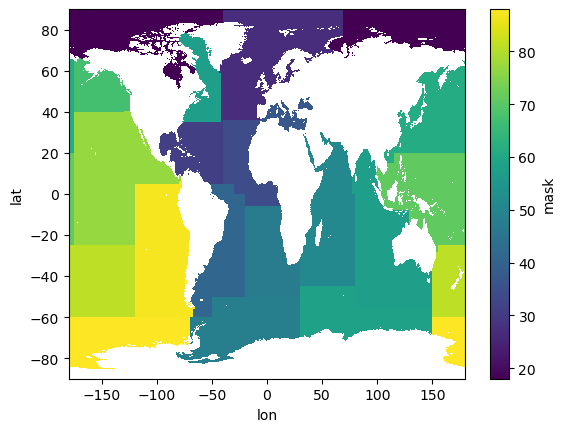

In [35]:
#We will go through each index and replace it with the ID for the region
for ind in fao.index:
    mask = xr.where(mask == ind, fao.F_CODE[ind], mask)

# Fixing region 21
mask = xr.where((mask_fao == 57) & (mask_fao.lat > 30), 21, mask)

#Plotting results
mask.plot()

Now the mask matches the original shapefile. We can now save the mask so it can be used at a later time. 

In [36]:
f_out = os.path.join('/g/data/vf71/shared_resources/fao_fishing_areas', 
                     f'gfdl-mom6-cobalt2_FAO_MajorAreas_{res_am}_global_fixed.nc')

mask.to_netcdf(f_out)

## Load boundaries for FAO Major Fishing Area 58: Indian Ocean, Antarctic And Southern
Our mask includes all FAO Major Fishing Areas, but the value `58` identifies the Indian Ocean, Antarctic And Southern area, which is what we will use as our study area.

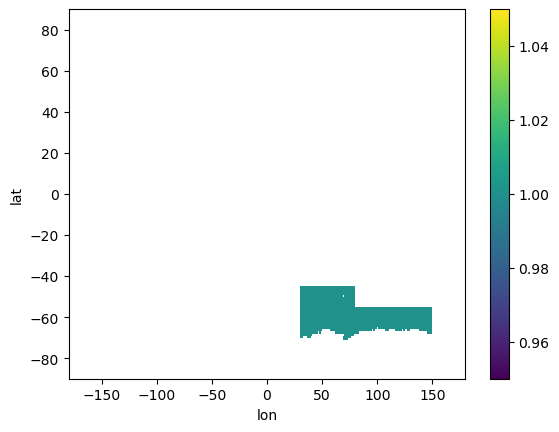

In [16]:
#Loading mask
mask_path = os.path.join('/g/data/vf71/shared_resources/fao_fishing_areas', 
                         f'gfdl-mom6-cobalt2_FAO_MajorAreas_{res_am}_global_fixed.nc')
mask = xr.open_dataarray(mask_path)

#Keeping only Indian Ocean, Antarctic Fishing Area
mask_fao = xr.where(mask == 58, 1, np.nan)

#Plotting results
mask_fao.plot()

## Get list of DBPM inputs from where data will be extracted
We will ignore `phypico-vint` and `phyc-vint` because they were used to calculate inputs for DBPM, but these variables are not actually needed as inputs.

In [22]:
region = 'east_antarctica'
fao_reg = 'fao-58'

file_list = glob(f'/g/data/vf71/la6889/dbpm_inputs/global_gridded/{res}/*')
#Ignoring files not needed
file_list = [f for f in file_list if '-vint_' not in f]

#Defining location of outputs
gfdl_out = f'/g/data/vf71/la6889/dbpm_inputs/{region}/gridded/{res}'
os.makedirs(gfdl_out, exist_ok = True)

In [25]:
#Extracting data for FAO area
for f in file_list:
    #Create file path to save outputs
    f_out = os.path.basename(f).replace('global', fao_reg)
    f_out = os.path.join(gfdl_out, f_out)
    #Apply function
    if fao_reg == 'fao-88':
        uf.extract_gfdl(f, mask_fao, f_out, cross_dateline = True)
    else:
        uf.extract_gfdl(f, mask_fao, f_out, cross_dateline = False)

## Calculating area-weighted means per time step
We will calculate the mean weighted by grid cell area for the variables processed in the previous step.

### Getting grid cell area values ready to be used as weights

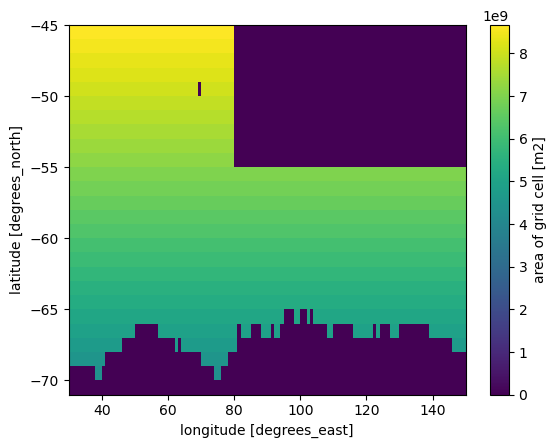

In [24]:
#Load area of grid cell to be used as weights
weights = xr.open_zarr(glob(os.path.join(gfdl_out, '*area*'))[0]).cellareao
#Areas outside LME need to be given a value of 0
weights = weights.fillna(0)
#Check result
weights.plot()

### Calculating weighted means for each GFDL experiment
This includes `obsclim`, `ctrlclim`, `spinup`, and `stable spinup`.

In [52]:
region_int = fao_reg.replace('-', ' ').upper()

weighted_obs_df = uf.weighted_mean_timestep(
    glob(os.path.join(gfdl_out, '*obsclim*')), weights, region_int)

weighted_ctrl_df = uf.weighted_mean_timestep(
    glob(os.path.join(gfdl_out, '*ctrlclim*')), weights, region_int)

weighted_spinup_df = uf.weighted_mean_timestep(
    glob(os.path.join(gfdl_out, '*spinup*')), weights, region_int)

weighted_stable_spin_df = uf.weighted_mean_timestep(
    glob(os.path.join(gfdl_out, '*stable-spin*')), weights, region_int)

#Adding depth from ctrlclim
[depth] = weighted_ctrl_df.depth_m.unique()
weighted_spinup_df['depth_m'] = depth
weighted_stable_spin_df['depth_m'] = depth

### Save outputs 

In [53]:
gfdl_out = f'/g/data/vf71/la6889/dbpm_inputs/{region}/monthly_weighted/{res}'
os.makedirs(gfdl_out, exist_ok = True)

weighted_obs_df.to_parquet(
    os.path.join(gfdl_out, 
                 f'obsclim_dbpm_clim-inputs_{fao_reg}_1961-2010.parquet'), 
    index = False)

weighted_ctrl_df.to_parquet(
    os.path.join(gfdl_out,
                 f'ctrlclim_dbpm_clim-inputs_{fao_reg}_1961-2010.parquet'), 
    index = False)

weighted_spinup_df.to_parquet(
    os.path.join(gfdl_out,
                 f'spinup_dbpm_clim-inputs_{fao_reg}_1841-1960.parquet'), 
    index = False)

weighted_stable_spin_df.to_parquet(
    os.path.join(gfdl_out, 
                 f'stable-spin_dbpm_clim-inputs_{fao_reg}_1741-1840.parquet'), 
    index = False)

## Extracting and saving sea ice mask per FAO region
Using the sea ice masks created in [01_processing_dbpm_global_inputs](scripts/01_processing_dbpm_global_inputs.ipynb), we will create masks identifying sea ice covered grid cells in the Southern Ocean. Sea ice covered cells will be set to `NA` to identify them as inacessible to fisheries when spreading fishing effort.

In [17]:
#Getting list of sea ice mask files
si_files = glob(f'/g/data/vf71/la6889/dbpm_inputs/global_gridded/{res}/*simask*')
#Defining region and fao code of interest
regs = {'west_antarctica': 'fao-88', 'east_antarctica': 'fao-58', 'weddell': 'fao-48'}
#Keeping only FAO Fishing Areas in the Southern Ocean
mask_so = xr.where(((mask == 48) | (mask == 58) | (mask == 88)), 1, np.nan)

In [18]:
# Create masks for all sea ice files
for f in si_files:
    #Load file
    da = xr.open_zarr(f)['simask']
    #Keep grid cells for the Southern Ocean only and add up grid cells along latitude
    da_so = da.where(mask_so == 1, drop = True).cumsum('lat')*mask_so
    #Identify grid cells with values above 0 as sea ice covered and assign NA
    da_mask = xr.where(da_so > 0, np.nan, 1)*mask_so
    da_mask.name = 'simask'
    #Loop through Southern Ocean regions
    for k in regs:
        #Define path where outputs will be saved
        gfdl_out = f'/g/data/vf71/la6889/dbpm_inputs/{k}/gridded/{res}'
        #Get mask for FAO region - Based on area of grid cell (ocean model)
        mask_reg = xr.open_zarr(glob(os.path.join(gfdl_out, '*area*'))[0])['cellareao']
        #Make binary mask
        mask_reg = xr.where(np.isfinite(mask_reg), 1, np.nan).compute()
        #Create file path to save sea ice mask
        f_out = os.path.join(gfdl_out, 
                             os.path.basename(f).replace('global', regs[k]))
        #Extract sea ice mask for each region
        if k == 'west_antarctica':
            da_reg = da_mask.copy()
            da_reg['lon'] = da_reg.lon%360
            da_reg = da_reg.sortby('lon')
            da_reg = da_reg.where(mask_reg == 1, drop = True)
        else:
            da_reg = da_mask.where(mask_reg == 1)
        da_reg = da_reg.sortby('lat', ascending = False)
        #Rechunking data before saving
        da_reg = da_reg.chunk({'time': '50MB', 'lat': len(da_reg.lat), 'lon': len(da_reg.lon)})
        #Save results
        da_reg.to_zarr(f_out, consolidated = True, mode = 'w')